# `qfit` Quick Start


Tianpu Zhao, Danyang Chen and Jens Koch

This guide will walk you through the basic usage of `qfit` and its features. We have prepared a simple task for you to practice fitting with `qfit`. Don't worry, we've also prepared a detailed guide for you to follow. 

#### Scope of the app

Please notice that the current version of the app supports for any circuit (including both hard-coded qubit classes and those generated with the custom circuit module) and composite system with one tunable parameter (i.e. external flux and offset charge). In the upcoming release, we will implement supports for circuits with multiple tuning knobs and crosstalk calibrations for flux/charge lines.

## The task

You are given a **superconducting circuit** composed of a fluxonium qubit and a resonator mode. They are capacitively coupled. The effective circuit is shown below:
<p align="center">
  <img width="300" src="resources/images/example_circuit.png">
</p>  

This circuit is described by the following **Hamiltonian**:
$$
H = H_{\rm res} + H_{\rm qubit} + H_{\rm int}
$$
with the resonator and qubit Hamiltonians and their interactions given by
\begin{align*}
H_{\rm res} &= E_{\rm osc} a^\dagger a \\
H_{\rm qubit} &= 4E_C n^2 - E_J \cos(\varphi+2\pi\Phi_{\rm ext}/\Phi_0) + \frac{1}{2}E_L\varphi^2 \\
H_{\rm int} &= g \frac{-i}{\sqrt{2}l_{\rm osc}} (a-a^\dagger) n
\end{align*}
where $a$ is the annihilation operator of the resonator, $n$ ($\varphi$) is the number (phase) operator of the qubit. $\Phi_{\rm ext}$ is the external flux, and $\Phi_0$ is the flux quantum.  Circuit parameters and their estimates (typically obtained from EM simulations and the Ambegaokar–Baratoff relation) are listed below:

| Parameter | Symbol | Rough Estimate |
| --- | --- | --- |
| Josephson Energy | $E_J$ | $3.0\ GHz\times h$ |
| Charging Energy | $E_C$ | $0.9\ GHz\times h$ |
| Inductive Energy | $E_L$ | $0.25\ GHz\times h$ |
| Oscillator Length | $l_{\rm osc}$ | $1.0$ |
| Resonator Frequency | $E_{\mathrm{osc}}$ | $5.6\ GHz\times h$ |
| Coupling Strength | $g$ | $1.0 \ GHz\times h$ |

To determine the parameter described above, one can perform a **two-tone spectroscopy experiment**. In the experiment, two tones of RF drive are applied to the system - a tone with frequency $f_{\rm d}$ to the qubit and a tone near frequency $E_{\rm osc} / h$ to the resonator. One then measure the transmission or reflection of the RF signal through the resonator. If the qubit drive pulse frequency $f_{\rm d}$ happens to match a transition frequency of the qubit-resonator system, then the pulse may drive this transition. This may introduce a shift on the resonator frequency, which changes the amplitude and phase of the transmission/reflection signal.

By performing such measurement for different $f_{\rm d}$ and $\Phi_{\rm ext}$, one can obtain the following data:

Below is the information of the data and the shape of elements:
freq (2793,)
mags (81, 2793)
voltage (81,)


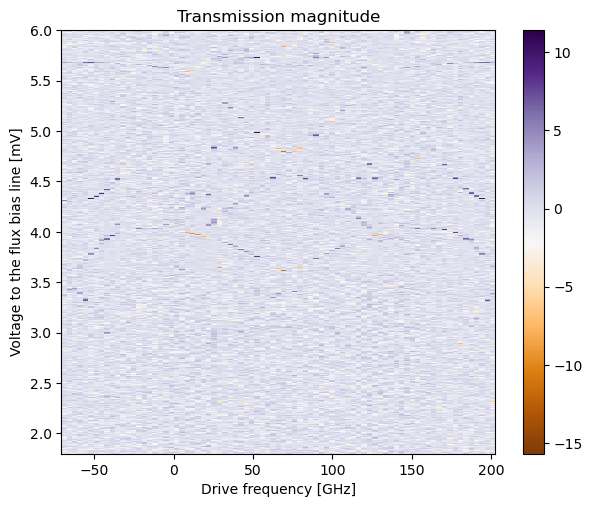

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Load the data in the h5 file (you don't need to do this while using QFit)
print("Below is the information of the data and the shape of elements:")
with h5py.File("./example_data/joint_qubit_twotone.h5", "r") as file:
    def print_info(name, obj):
        print(name, obj.shape)
    file.visititems(print_info)

    data = np.array(file["mags"])
    f_d, Phi_ext = np.meshgrid(file["freq"], file["voltage"])

# Plot the data
plt.figure(figsize=(7, 5.5))
plt.pcolormesh(Phi_ext.T, f_d.T, data.T, cmap="PuOr", rasterized=True)
plt.colorbar()
plt.xlabel("Drive frequency [GHz]")
plt.ylabel("Voltage to the flux bias line [mV]")
plt.title("Transmission magnitude")
plt.show()

In the data, the peaks represent resonances between the $f_{\rm d}$ and the transition frequencies. **Your task is to fit the data and extract the parameters.** - This is where `qfit` comes in. 


**Tips**

`qfit` supports various input data format including hdf5, matlab, and even images. We hope to make `qfit` as easy to use as possible. Reach out to us if you want to use `qfit` with your own data format.

## Step 0: Build a numerical model and run `qfit`

We have helped you to create a numerical model of the quantum system using `scqubits.HilbertSpace`. To see the usage of `scqubits` in detail, please refer to the [scqubits documentation](https://scqubits.readthedocs.io/en/latest/).

In [2]:
import scqubits as scq

fluxonium = scq.Fluxonium(
    EJ = 3.0,
    EC = 0.9,
    EL = 0.25,
    flux = 0.5,
    cutoff = 100,
    truncated_dim = 5,
    id_str = "Fluxonium"
)

resonator = scq.Oscillator(
    E_osc = 5.6,
    l_osc = 1.0,
    truncated_dim = 4,
    id_str = "Resonator"
)

hilbertspace = scq.HilbertSpace([fluxonium, resonator])

hilbertspace.add_interaction(
    g = 1,
    op1 = resonator.n_operator,
    op2 = fluxonium.n_operator,
    add_hc = False,
    id_str = "res-qubit"
)

#### Provide experimental data and launch `qfit`


Open the app using `Fit(<HilbertSpace>, <data file path>)`. An app (the graphical user interface, GUI) will pop up and we'll guide you through the GUI in the next few subsections. You may treat the following sections as a documentation and refer to it if necessary. Also you may click on the ? buttons for help.

In [3]:
filepath = "./example_data/joint_qubit_twotone.h5"
# filepath = "./example_data/transmons.jpg"

In [4]:
from qfit import Fit
fit = Fit(hilbertspace, filepath)

qt.qpa.fonts: Populating font family aliases took 230 ms. Replace uses of missing font family "Roboto Medium" with one that exists to avoid this cost. 


In [26]:
from PySide6.QtGui import QIcon

#### An overview of the GUI


After launching the GUI, you will see a window below. The window is divided into parts as shown here. 
<p align="center">
  <img width="600" src="resources/images/example_GUI_overview.png">
</p>  

The fitting task is divided into 4 steps and you can navigate through them using the navigation menu. The 4 steps are: **Calibrate**, **Extract**, **Pre-Fit** and **Fit**. Let's go through them one by one and you may perform the corresponding task as you read along.

## Step 1: Calibrate

#### Orient your data correctly


After launching the app, you may find your data not oriented as expected. The x-axis should be the parameter (e.g. the DC voltage) that you swept in an experiment, and the y-axis should be frequency for the qubit tone. You may click "Switch X And Y Axis" button to orient your figure correctly.

#### The calibration process

The first window you'll see after launching the GUI is the calibration panels. The aim of the calibration is to:
1. map the x-axis of experimental data (here is the flux bias line voltage in mV) to the swept parameter in `scqubits` (here is the external flux in $\Phi_0$). This also applies to circuits that are tuned by offset charges in analogy.
2. map the y-axis of experimental data to frequencies **in unit of GHz**. In this example the experimental y-axis is already in GHz.  

Assuming a linear relationship between the flux bias line voltage ($x$) and external flux ($x'$), i.e. $x' = ax + b$, calibrating for their relation requires two pairs of $(x, x')$ values.
<p align="center">
    <img width="500" src="resources/images/calibration_notebook_ver.png">
</p>  


To calibrate for $x$ in `qfit`, follow these steps:
1. Click the calibration point selection button for $x_1$. 
2. From the spectrum, identify/guess a zero-flux point and click. The $x_1$ coordinate will be automatically extracted.  
3. Enter the value $x_1^\prime$, which is 0.0 flux quantum.  
4. Repeat the above steps for $x_2$.  
    
You can also check out the video below for a demonstration.
<video src="resources/videos/calibration.mp4" width="840" height="560" controls align="center">
[Your browser does not support the video tag.]
</video>

**Tips**

1. For a fluxonium, the Hamiltonian is periodic in flux with period $\Phi_0$ and symmetric around $\Phi_{\rm ext} = \frac{m}{2} \Phi_0$, where $m$ is an integer. Therefore, we can identify and map the x coordinates with those properties.
2. You may switch your cursor to zoom/pan mode, and continue picking up the raw x/y value by switching back to the extract mode.

### Step 2: Extract

Now let's navigate to the next step and work on the data extraction. In QFit, extracted peak data are grouped by transitions. For example, we believe a spectral line in the data belongs to the plasmon transition $|\overline{0_{\rm res},0_{\rm qubit}}\rangle \rightarrow|\overline{0_{\rm res},2_{\rm qubit}}\rangle$. And here is a step-by-step guide to extract and label the data:

1. Select / Create a group of transition data and label it. In this case, we uses bare state label (0, 0) --> (0, 2):
<p align="center">
    <img width="300" src="resources/images/example_transition_n_label.png">
</p>  
   
2. Click on the canvas near a peak to select it. There a few helpful tools for you in this step (see tips below). Here is how it looks.
<p align="center">
    <img width="300" src="resources/images/example_extract02.png">
</p>  

3. If you want to increase the fitting accuracy, extract more transitions as shown below by repeating step 1, 2.

**Tips**

To assist you in the data extraction, the following button will be useful in the canvas.
<p align="center">
    <img width="500" src="resources/images/example_MPL_buttons.png">
</p>  

They are (from left to right): **Reset | Pan, Zoom, Extract | X-Snap, Y-Snap | Show Calibrated Axes**. 

1. Specifically, the **X-Snap** button helps to align the x-coordinate among different transitions (groups).
<p align="center">
    <img width="200" src="resources/gifs/X_snap.gif">
</p>  

Since numerical transition calculations will be carried out at every distinctive flux (x) values, we suggest you extract points from different transitions along the same x-value as much as possible. This is facilitated by the **X-Snap** button.
<p align="center">
    <img width="400" src="resources/images/example_same_x_preferred.png">
</p>

2. **Choose your points wisely!** More points with distinctive x-value being selected = longer calculation time. You may want to select representative points for fitting.

3. And the **Y-Snap** button assists you to locate the peak precisely.
<p align="center">
    <img width="200" src="resources/gifs/Y_snap.gif">
</p>

4. To **delete points**, click on the vicinity of the extracted point.

5. For transitions, selecting bare or dressed labels means that you mark your initial and final states using bare indices (states are labelled by excitations of individual subsystems) or dressed indices (states are regarded as eigenstates of the entire system and labelled as 0, 1, 2, 3,... in ascending order of energy). 

6. If you do not know what label should be given to a group of points, you may choose the "Unknown" label, and come back to label it later once you have a better idea. 

7. Transitions may not necessarily start from the ground states; sometimes a higher-lying states are populated so the transitions from this high-lying state is activated.

#### Settings: visual

The visual settings may improves the image contrast and help you locate peaks easier. 
<p align="center">
    <img width="200" src="resources/images/settings_visual.png">
</p>

### Step 3: Pre-Fit

After getting enough data, we now start to fit by eye, aiming to find a good initial guess for the numerical fitting. In this step, you may play with **sliders** to make the numerical spectrum match the data. 

You may also fine-tune your calibration by adjusting the mapped value of your points selected for calibration.

After getting a good set of parameters, you will click **Result To Fit** button on the bottom left to copy the parameters to the <span style="color:rgb(190, 130, 250);">FIT</span> panel.

#### Settings: spectrum

Options in the spectrum settings can change what transitions are plotted, and how these transitions are marked.

<p align="center">
    <img width="200" src="resources/images/settings_spectrum.png">
</p>

1. TRANSITIONS: transitions that **only** excites the selected subsystem selected are labelled in color; the dashed lines are other transitions. 
2. INITIAL STATE: the initial state of the transition, can either be specified in bare state label or dressed state index.
3. EVALS COUNT: number of eigenvalues evaluated during parameter sweep.
4. POINTS ADDED: to make the transition curve look smooth, we include more sweep points for parameter sweep, in addition to those included in the extracted data.
5. PHOTONS: number of photons involved in the transition process. The transition frequency is ${|\mathrm{final\,energy} - \mathrm{initial\,energy}|}/{\mathrm{photon\,number}}$.

### Step 4: Fit
Finally, we are ready to fit the data numerically! The main thing you need to do is configure the fitting parameters in the **FIT table**. You may adjust the following entries in the table:
- Whether to **Fix** or free a parameter during fitting
- The **Initial** guesses (from pre-fit)
- **Min** and **Max** values

Now click **Run Fit** and wait for the fitting to finish. 

If there is not warning or error message, congratulations! You have successfully fit the data and the fit parameters can be found in **Current** column. 

If you want to make use of the fitting result as a initial guess, and repeat the numerical fitting with different configurations, you may click **Result To Initial**.

## Save, load and export
You may save / load the fitting session by clicking the <img width="20" src="resources/images/example_menu.png"> button on the top left. The session will be saved as a `.qfit` file.

You can also open a new window to load the previous session.

In [1]:
from qfit import Fit
# this is an example file we already prepared for you
# If you didn't close the previous window, you'll get another one
fit = Fit.open("example_data/QFit_Quick_Start.qfit") 

qt.qpa.fonts: Populating font family aliases took 86 ms. Replace uses of missing font family "Roboto Medium" with one that exists to avoid this cost. 


	updateCalc called, prefit
	new sweep
	updateCalc called, prefit
	new sweep
	updateCalc called, prefit
	new sweep
	updateCalc called, prefit
	new sweep


In [5]:
fit._plottingCtrl.dataDestination

'NONE'

In [2]:
fit._plottingCtrl.pageView.pageChanged.connect(
    lambda page: print(page)
)

Data destination: NONE
prefit
Data destination: NONE
Data destination: NONE
Data destination: EXTRACT
extract
Data destination: NONE


There is another option for you to continue working in the notebook - export.

In [2]:
# To get the HilbertSpace object and continue working on it
fit_hilbertspace = fit.exportHilbertSpace(deepcopy=True)
fit_hilbertspace

HilbertSpace(**{'subsystem_list': [Fluxonium(**{'EJ': 3.3728, 'EC': 1.0515, 'EL': 0.2017, 'flux': 0.971708185053381, 'cutoff': 100, 'truncated_dim': 5, 'id_str': 'Fluxonium', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None}), Oscillator(**{'E_osc': 5.5929, 'l_osc': 1.0, 'truncated_dim': 4, 'id_str': 'Resonator'})], 'interaction_list': [InteractionTerm(**{'g_strength': 1.1441, 'operator_list': [(1, <bound method Oscillator.n_operator of Oscillator(**{'E_osc': 5.5929, 'l_osc': 1.0, 'truncated_dim': 4, 'id_str': 'Resonator'})>), (0, <bound method Fluxonium.n_operator of Fluxonium(**{'EJ': 3.3728, 'EC': 1.0515, 'EL': 0.2017, 'flux': 0.971708185053381, 'cutoff': 100, 'truncated_dim': 5, 'id_str': 'Fluxonium', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None})>)], 'add_hc': False})]})

## Final words
We hope you have enjoyed this tutorial and learned how to use `QFit`. If you have any questions, please feel free to contact us.